In [1]:
from argparse import ArgumentParser, Namespace
from pathlib import Path
import pickle
import sys

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange

In [2]:
from IPython.display import HTML

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append(str(Path(".").resolve().parent))
import berp.models.reindexing_regression as rr

In [5]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [6]:
p = ArgumentParser()
p.add_argument("natural_language_stimulus_path", type=Path)
p.add_argument("confusion_path", type=Path)

_StoreAction(option_strings=[], dest='confusion_path', nargs=None, const=None, default=None, type=<class 'pathlib.Path'>, choices=None, required=True, help=None, metavar=None)

In [7]:
if IS_INTERACTIVE:
    args = Namespace(natural_language_stimulus_path=Path("gillis2021/DKZ_1.pkl"),
                     confusion_path=Path("gillis2021/confusion.npz"))
else:
    args = p.parse_args()

In [8]:
with args.natural_language_stimulus_path.open("rb") as f:
    stim = pickle.load(f)
confusion = np.load(args.confusion_path)

In [9]:
assert confusion["phonemes"].tolist() == stim.phonemes

In [10]:
confusion_matrix = torch.tensor(confusion["confusion"])

# Smooth and normalize.
confusion_matrix += 1.
confusion_matrix /= confusion_matrix.sum(dim=0, keepdim=True)

In [11]:
p_candidates = rr.predictive_model(
    stim.p_word, stim.candidate_phonemes,
    confusion=confusion_matrix,
    lambda_=torch.tensor(1.),  # TODO,
    return_gt_only=False)

In [12]:
# Nested array. Outer list of words and inner list of phonemes per word.
plot_data = []

k = 10
for p_candidates_i, candidates, gt_length in zip(tqdm(p_candidates), stim.candidate_phonemes, stim.word_lengths):
    candidate_strs = ["".join(stim.phonemes[idx.item()].rstrip("_") for idx in word)
                      for word in candidates]
    plot_data_i = []
    
    p_candidates_i = p_candidates_i.T.numpy()[:gt_length]
    topk = (-p_candidates_i).argsort(1)[:, :k]
    p_candidates_i = np.take_along_axis(p_candidates_i, topk, 1)
    for t, (p_candidates_t, candidates_t) in enumerate(zip(p_candidates_i, topk)):
        plot_data_i.append((candidate_strs[0][:t + 1], list(zip(p_candidates_t, [candidate_strs[idx] for idx in candidates_t]))))
        
    plot_data.append(plot_data_i)

  0%|          | 0/2190 [00:00<?, ?it/s]

In [13]:
class PredictiveAnimation:
    
    def __init__(self, plot_data, k=3, threshold=0.7):
        self.plot_data = plot_data
        # Mapping between frame index and plot_data nested index.
        self.plot_idxs_flat = [(i, j) for i in range(len(plot_data)) for j in range(len(plot_data[i]))]

        self.k = k
        self.threshold = threshold
        
        self._prepare_figure()
        
    def _prepare_figure(self):
        self.fig, self.ax = plt.subplots()

        self.ax.set_xlim((0, 1))
        self.ax.set_xlabel("Evidence for word")
        self.ax.set_ylabel("Word")

        self.bar = self.ax.barh([str(i) * 15 for i in range(self.k)], [0] * self.k)
        self.threshold_line = self.ax.axvline(self.threshold, color="gray", linestyle="--")
        self.prev_label = self.ax.annotate("", (0.49, 0.85), xycoords="axes fraction", ha="right")
        self.incremental_label = self.ax.annotate("abc", (0.5, 0.85), xycoords="axes fraction")
        self.prev_incremental_text = [None]
        self.acc_text = []
        
    def get_first_frame_for_word_idx(self, word_idx):
        return next(i for i, (word_idx_i, _) in enumerate(self.plot_idxs_flat) if word_idx_i == word_idx)
        
    def animate(self, i):
        token_idx, incremental_idx = self.plot_idxs_flat[i]
        incremental_text, incremental_dist = self.plot_data[token_idx][incremental_idx]
        print(incremental_text)
        print(incremental_dist)

        xticklabels = self.ax.get_xticklabels()
        artists = list(self.bar) + xticklabels

        for i, ((p_i, option_i), bar_i, label_i) in enumerate(zip(incremental_dist, self.bar, xticklabels)):
            bar_i.set_width(p_i)

            # Doesn't work .. do it differently below
            # label_i.set_text(option_i)

        self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])
        self.ax.tick_params("y", width=10)

        if self.prev_incremental_text[0] is not None and not incremental_text.startswith(self.prev_incremental_text[0]):
            self.acc_text.append(prev_incremental_text[0])
            self.prev_label.set_text(" ".join(acc_text))
            artists.append(self.prev_label)

        self.incremental_label.set_text(incremental_text)
        artists.append(self.incremental_label)
        self.prev_incremental_text[0] = incremental_text

        return artists
    
    def plot(self, start_frame=None, n_frames=100, kwargs=None):
        plt.ioff()
        if start_frame is None: start_frame = 0
        
        default_kwargs = dict(blit=True, repeat=True, interval=750)
        if kwargs is not None:
            default_kwargs.update(kwargs)
        
        anim = FuncAnimation(self.fig, self.animate, frames=list(range(start_frame, start_frame + n_frames)),
                             **default_kwargs)
        return HTML(anim.to_html5_video())

k
[(0.7014116173775149, 'klɛinə'), (0.07461965160494644, 'də'), (0.05971807603688842, 'twe'), (0.05003370856580871, 'erstə'), (0.032754172086010135, 'ən'), (0.02935979950471179, 'də'), (0.018735951632066827, 'ɪn'), (0.012781782850021909, 'xrotə'), (0.010797525279562637, 'ɑndərə'), (0.009787715062468082, 'latstə')]
k
[(0.7014116173775149, 'klɛinə'), (0.07461965160494644, 'də'), (0.05971807603688842, 'twe'), (0.05003370856580871, 'erstə'), (0.032754172086010135, 'ən'), (0.02935979950471179, 'də'), (0.018735951632066827, 'ɪn'), (0.012781782850021909, 'xrotə'), (0.010797525279562637, 'ɑndərə'), (0.009787715062468082, 'latstə')]
k
[(0.7014116173775149, 'klɛinə'), (0.07461965160494644, 'də'), (0.05971807603688842, 'twe'), (0.05003370856580871, 'erstə'), (0.032754172086010135, 'ən'), (0.02935979950471179, 'də'), (0.018735951632066827, 'ɪn'), (0.012781782850021909, 'xrotə'), (0.010797525279562637, 'ɑndərə'), (0.009787715062468082, 'latstə')]


/tmp/ipykernel_65575/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])
/tmp/ipykernel_65575/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])


kl
[(0.9934339734917261, 'klɛinə'), (0.0022258108954782193, 'twe'), (0.001587056672309549, 'ən'), (0.0009078238024657926, 'ɪn'), (0.0005594566053911414, 'erstə'), (0.0005231786806994319, 'ɑndərə'), (0.00041086235745253476, 'də'), (0.0001616576354805712, 'də'), (0.00014292070384338076, 'xrotə'), (4.725915515330476e-05, 'latstə')]
klɛ
[(0.9999686047186139, 'klɛinə'), (1.9567265344684207e-05, 'twe'), (3.487982636712315e-06, 'ən'), (3.162019990556345e-06, 'ɑndərə'), (1.9951862560691387e-06, 'ɪn'), (1.3832504091384587e-06, 'erstə'), (9.029802110265242e-07, 'də'), (3.5528600552597185e-07, 'də'), (3.141065735900727e-07, 'xrotə'), (2.27203958815586e-07, 'latstə')]
klɛi
[(0.9999998737493979, 'klɛinə'), (5.7548426674412493e-08, 'erstə'), (3.015081234717485e-08, 'twe'), (1.4395414368431577e-08, 'ɑndərə'), (1.3068016462368432e-08, 'xrotə'), (5.3745634914838646e-09, 'ən'), (3.074343059427337e-09, 'ɪn'), (1.3913843562850899e-09, 'də'), (7.001881771532239e-10, 'latstə'), (5.474531823171201e-10, 'də')

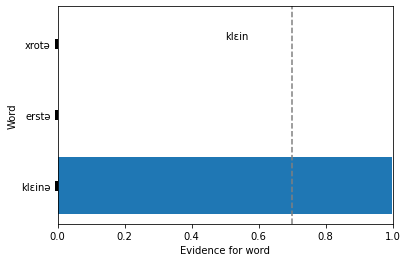

In [14]:
PredictiveAnimation(plot_data).plot(n_frames=5)

## Index candidates by feature

In [15]:
def to_gt_words(word_ids):
    return [stim.get_candidate_strs(idx, top_k=1)[0]
            for idx in word_ids]

In [16]:
def anim_word_idx(word_idx, **kwargs):
    """
    Render an animation excerpt of the perception of word at `word_idx`.
    """
    anim = PredictiveAnimation(plot_data)
    start_frame = anim.get_first_frame_for_word_idx(word_idx)
    return anim.plot(start_frame=start_frame, n_frames=stim.word_lengths[word_idx].item())

### Find low-prior ground truth words

In [17]:
k = 5
low_prior_word_ids = stim.p_word[:, 0].argsort()[:k]
low_prior_words = to_gt_words(low_prior_word_ids)
low_prior_words

['ɔptorndə', 'en', 'bluməntœyntjə', 's', 'blekjəs']

### Find words which are still low-posterior at phoneme $k$

In [18]:
k = 5
n = 20

# Only include words which are still running at phoneme $k$
mask = stim.word_lengths > k
p_candidates_masked = p_candidates.clone()
p_candidates_masked[~mask] = torch.inf

low_posterior_word_ids = p_candidates_masked[:, 0, k].argsort()[:n]
low_posterior_words = to_gt_words(low_posterior_word_ids)
list(zip(low_posterior_word_ids, low_posterior_words))

[(tensor(793), 'ɑndərə'),
 (tensor(233), 'ɑndərə'),
 (tensor(852), 'vərtɛlt'),
 (tensor(292), 'ɑndərə'),
 (tensor(579), 'xəhɑkt'),
 (tensor(857), 'wɪldəw'),
 (tensor(1701), 'ɔptorndə'),
 (tensor(731), 'voxəltjəsh'),
 (tensor(493), 'ɑndərr'),
 (tensor(1724), 'krœndəh'),
 (tensor(1775), 'bɑlkən'),
 (tensor(309), 'zalənk'),
 (tensor(655), 'lœkərst'),
 (tensor(81), 'prɑxtəxstə'),
 (tensor(172), 'beldəxhɛitxə'),
 (tensor(1390), 'ɔpxətɪltk'),
 (tensor(1956), 'bəxɔnə'),
 (tensor(596), 'plɑntə'),
 (tensor(262), 'mojstə'),
 (tensor(1631), 'ɑndərə')]

In [19]:
p_candidates[low_posterior_word_ids, 0, k]

tensor([0.1585, 0.2183, 0.3456, 0.4288, 0.8179, 0.9659, 0.9661, 0.9683, 0.9974,
        0.9982, 0.9992, 0.9997, 0.9998, 0.9998, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], dtype=torch.float64)

v
[(0.39337912734987324, 'vrht'), (0.3790544003287525, 'vərtɛlt'), (0.2001900680846229, 'vərtɛlt'), (0.018661012305281353, 'xəzin'), (0.0028447559463751003, 'mer'), (0.001825732897099889, 'kʏnə'), (0.001423141574853867, 'nodəx'), (0.001290247092317434, 'ens'), (0.000753458100138016, 'xəvɔndə'), (0.0005780563206857979, 'erdər')]
v
[(0.39337912734987324, 'vrht'), (0.3790544003287525, 'vərtɛlt'), (0.2001900680846229, 'vərtɛlt'), (0.018661012305281353, 'xəzin'), (0.0028447559463751003, 'mer'), (0.001825732897099889, 'kʏnə'), (0.001423141574853867, 'nodəx'), (0.001290247092317434, 'ens'), (0.000753458100138016, 'xəvɔndə'), (0.0005780563206857979, 'erdər')]
v
[(0.39337912734987324, 'vrht'), (0.3790544003287525, 'vərtɛlt'), (0.2001900680846229, 'vərtɛlt'), (0.018661012305281353, 'xəzin'), (0.0028447559463751003, 'mer'), (0.001825732897099889, 'kʏnə'), (0.001423141574853867, 'nodəx'), (0.001290247092317434, 'ens'), (0.000753458100138016, 'xəvɔndə'), (0.0005780563206857979, 'erdər')]
və
[(0.612

/tmp/ipykernel_65575/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])
/tmp/ipykernel_65575/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])


vər
[(0.6540535821950197, 'vərtɛlt'), (0.3454254350748943, 'vərtɛlt'), (0.0002859373089523147, 'mer'), (0.00016070284335836273, 'vrht'), (4.653083979330747e-05, 'xəzin'), (1.790031737088486e-05, 'kʏnə'), (9.393659243922579e-06, 'xəvɔndə'), (3.4452169316582975e-07, 'nodəx'), (1.142029281426575e-07, 'ens'), (5.903674591309695e-08, 'erdər')]
vərt
[(0.6542878313618598, 'vərtɛlt'), (0.3455491491291773, 'vərtɛlt'), (0.0001607603990513371, 'vrht'), (1.1044004530713151e-06, 'mer'), (8.332477167581673e-07, 'xəzin'), (2.0427120810826865e-07, 'kʏnə'), (1.1214419156229531e-07, 'xəvɔndə'), (3.931542722083671e-09, 'nodəx'), (6.737035528802487e-10, 'erdər'), (4.4109586833894266e-10, 'ens')]
vərtɛ
[(0.6543944181607523, 'vərtɛlt'), (0.3456054408342959, 'vərtɛlt'), (1.378958728421142e-07, 'vrht'), (1.742171677963881e-09, 'xəzin'), (9.473244987085545e-10, 'mer'), (2.3447341103808903e-10, 'xəvɔndə'), (1.7521825464993783e-10, 'kʏnə'), (4.875900292173496e-12, 'erdər'), (4.6370084791149874e-12, 'nodəx'), (3.

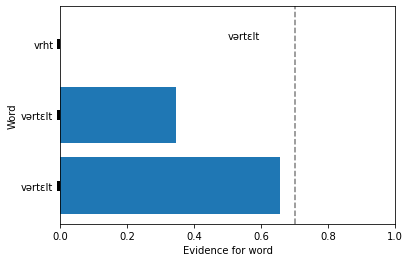

In [20]:
anim_word_idx(852)

### Find words which are not the MAP at phoneme $k$

In [61]:
p_candidates.shape

torch.Size([2187, 1000, 16])

In [69]:
k = 5

# Only include words which are still running at phoneme $k$
mask = stim.word_lengths > k
p_candidates_masked = p_candidates.clone()
p_candidates_masked[~mask] = -torch.inf
p_candidates_argmax = p_candidates_masked[:, k].argmax(dim=1)

not_argmax_idxs = torch.where(p_candidates_argmax != 0)[0]
list(zip(not_argmax_idxs, to_gt_words(not_argmax_idxs)))

[(tensor(15), 'mojstə'),
 (tensor(27), '#dipər'),
 (tensor(37), 'heləbul'),
 (tensor(63), 'zemənsə#x'),
 (tensor(89), 'bladrə'),
 (tensor(114), '#ɑləmal#x#'),
 (tensor(175), '#idərə'),
 (tensor(228), '#ustərs'),
 (tensor(233), 'ɑndərə'),
 (tensor(238), 'zɛs#ɪs'),
 (tensor(239), 'vɛrdər'),
 (tensor(240), 'vərdində'),
 (tensor(264), 'ɑləmal#r'),
 (tensor(282), 'merə#x'),
 (tensor(456), '#pʏrpərən'),
 (tensor(506), '#maktə'),
 (tensor(529), 'xəkert#xə'),
 (tensor(592), 'xəkomə'),
 (tensor(628), 'bəwox#xə'),
 (tensor(655), 'lœkərst'),
 (tensor(865), 'vərlɑŋənt'),
 (tensor(869), 'dəxenə'),
 (tensor(898), 'kɛikə#h#'),
 (tensor(950), 'zwɔm#h'),
 (tensor(967), 'zemermɪnətjə'),
 (tensor(974), '#œyjtstrɛktə'),
 (tensor(980), 'vɛiftin'),
 (tensor(990), 'hɔndərt'),
 (tensor(996), 'herləkstə'),
 (tensor(1007), '#kɑlmə'),
 (tensor(1010), 'lɪxə#xə'),
 (tensor(1043), 'rɛijtœyjxən'),
 (tensor(1082), 'darnax'),
 (tensor(1357), 'hɔndərt'),
 (tensor(1359), 'lɑntarnsh'),
 (tensor(1423), 'zɛstin'),
 (tensor

In [71]:
anim_word_idx(37)

h
[(0.2843737857954816, 'hel'), (0.11503773708401324, 'helə'), (0.04161625407498444, 'ht'), (0.030969074349699508, 'ht'), (0.027556656173453757, 'heləbul'), (0.02208031511063773, 'hɑrt'), (0.01865259578798935, 'h'), (0.014280507235832797, 'ha'), (0.012843420209193216, 'hɑnt'), (0.010211893493392134, 'hoxə')]
h
[(0.2843737857954816, 'hel'), (0.11503773708401324, 'helə'), (0.04161625407498444, 'ht'), (0.030969074349699508, 'ht'), (0.027556656173453757, 'heləbul'), (0.02208031511063773, 'hɑrt'), (0.01865259578798935, 'h'), (0.014280507235832797, 'ha'), (0.012843420209193216, 'hɑnt'), (0.010211893493392134, 'hoxə')]
h
[(0.2843737857954816, 'hel'), (0.11503773708401324, 'helə'), (0.04161625407498444, 'ht'), (0.030969074349699508, 'ht'), (0.027556656173453757, 'heləbul'), (0.02208031511063773, 'hɑrt'), (0.01865259578798935, 'h'), (0.014280507235832797, 'ha'), (0.012843420209193216, 'hɑnt'), (0.010211893493392134, 'hoxə')]
he
[(0.6092247775663425, 'hel'), (0.24644971965575924, 'helə'), (0.059

/tmp/ipykernel_60813/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])
/tmp/ipykernel_60813/4229271781.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels([option_i for _, option_i in incremental_dist])


helə
[(0.7967883806543204, 'helə'), (0.19086626706381407, 'heləbul'), (0.009561477370025783, 'hel'), (0.0007058671381728866, 'hɛiləxə'), (0.0005689674464068114, 'hekəl'), (0.0004017861372421666, 'hɛiləx'), (0.00020622559791568684, 'heməl'), (0.00010486451961581173, 'hetə'), (6.861690441805815e-05, 'relixjœzə'), (6.518453824514022e-05, 'penəs')]
heləb
[(0.9925745083818459, 'heləbul'), (0.0073079214554912335, 'helə'), (8.76952115707618e-05, 'hel'), (6.47401710293987e-06, 'hɛiləxə'), (5.218411199292192e-06, 'hekəl'), (3.685070721613382e-06, 'hɛiləx'), (2.3126329349481686e-06, 'xəlʏk'), (1.8914438366206418e-06, 'heməl'), (1.1957089163794259e-06, 'penəs'), (9.617882130646226e-07, 'hetə')]
heləbu
[(0.9999942516993445, 'heləbul'), (5.628860856788864e-06, 'helə'), (6.75464489793558e-08, 'hel'), (1.99462140795383e-08, 'hɛiləxə'), (5.695692165012416e-09, 'relixjœzə'), (4.6872222371597065e-09, 'relixjœs'), (4.0194343512344055e-09, 'hekəl'), (2.838392621721737e-09, 'hɛiləx'), (1.7812847446340663e-